# Cargill Ocean Transportation Datathon 2026
## Freight Calculator & Vessel-Cargo Optimization

**Team Members:** [Your Team Name]

**Date:** January 2026

---

## Executive Summary

This notebook presents our solution for optimizing vessel-cargo allocation for Cargill's Capesize fleet. We:

1. Built a freight calculator to evaluate voyage profitability across **165 vessel-cargo combinations**
2. Applied machine learning (Gradient Boosting with 14 domain features) to simulate shipping risks
3. Performed scenario analysis on bunker prices and port delays
4. Developed an AI-powered chatbot (OpenAI GPT + Gradio UI) for interactive voyage recommendations

**Key Result:** Our recommended allocation generates a total portfolio profit of approximately **$5.17 million** across 3 optimal vessel-cargo pairings, with the portfolio naturally hedged against China port congestion (only 1 of 3 voyages discharges in China).

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from main_analysis import build_combinations_df

# SHAP is optional (may not be installed)
try:
    import shap
    _HAS_SHAP = True
except Exception:
    shap = None
    _HAS_SHAP = False
    print("⚠️ SHAP not installed. Skipping SHAP explainability for now (you can pip install shap).")

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.2f}".format)

# Plotting defaults
plt.rcParams["figure.figsize"] = (10, 5)

print("✓ Libraries loaded successfully")


# -------------------------
# Load project modules
# -------------------------
from freight_calculator import FreightCalculator, load_bunker_prices_flat
from vessel_cargo_data import (
    CARGILL_VESSELS,
    CARGILL_CARGOES,
    MARKET_VESSELS,
    MARKET_CARGOES,
    get_all_vessels,
    get_all_cargoes,
)

print("✓ Project modules loaded")


# -------------------------
# Load data files
# -------------------------
distances = pd.read_csv("Port_Distances.csv")

# Basic schema check (fail fast)
required_cols = {"PORT_NAME_FROM", "PORT_NAME_TO", "DISTANCE"}
missing = required_cols - set(distances.columns)
if missing:
    raise ValueError(f"Port_Distances.csv missing columns: {missing}")

bunker_prices = load_bunker_prices_flat()

# Initialize calculator
calc = FreightCalculator(distances, bunker_prices)

# Load vessel/cargo lists
all_vessels = get_all_vessels()
all_cargoes = get_all_cargoes()

print(f"✓ Loaded {len(distances):,} port distance records")
print(f"✓ Loaded bunker prices for {len(bunker_prices)} regions")
print(f"✓ {len(CARGILL_VESSELS)} Cargill vessels")
print(f"✓ {len(CARGILL_CARGOES)} committed cargoes")
print(f"✓ {len(MARKET_VESSELS)} market vessels")
print(f"✓ {len(MARKET_CARGOES)} market cargoes")
print(f"✓ Total combinations (vessels × cargoes): {len(all_vessels)} × {len(all_cargoes)} = {len(all_vessels) * len(all_cargoes)}")


✓ Libraries loaded successfully
✓ Project modules loaded
✓ Loaded 15,533 port distance records
✓ Loaded bunker prices for 8 regions
✓ 4 Cargill vessels
✓ 3 committed cargoes
✓ 11 market vessels
✓ 8 market cargoes
✓ Total combinations (vessels × cargoes): 15 × 11 = 165


## 2. Vessel & Cargo Overview

In [4]:
# =========================
# Vessel and Cargo Overview
# =========================

def _safe(v, key, default=None):
    return v.get(key, default)

# --- Vessels: Cargill Fleet ---
cargill_vessel_df = pd.DataFrame([{
    "Vessel": _safe(v, "name"),
    "DWT": _safe(v, "dwt"),
    "Hire Rate ($/day)": _safe(v, "hire_rate"),
    "Current Port": _safe(v, "current_port"),
    "ETD": _safe(v, "etd"),
    "ROB VLSF (MT)": _safe(v, "bunker_vlsf"),
    "ROB MGO (MT)": _safe(v, "bunker_mgo"),
    "Eco Speed Ballast (kn)": _safe(v, "eco_ballast_speed"),
    "Eco Speed Laden (kn)": _safe(v, "eco_laden_speed"),
    "War Speed Ballast (kn)": _safe(v, "war_ballast_speed"),
    "War Speed Laden (kn)": _safe(v, "war_laden_speed"),
    "Port VLSF Idle (t/day)": _safe(v, "port_vlsf"),
    "Port VLSF Work (t/day)": _safe(v, "port_mgo"),  # naming per your assumption
} for v in CARGILL_VESSELS])

print("\nCARGILL FLEET")
print("=" * 80)
display(cargill_vessel_df)


# --- Vessels: Market Fleet (hire may be unknown; that's OK) ---
market_vessel_df = pd.DataFrame([{
    "Vessel": _safe(v, "name"),
    "DWT": _safe(v, "dwt"),
    "Hire Rate ($/day)": _safe(v, "hire_rate"),  # will be None if not provided
    "Current Port": _safe(v, "current_port"),
    "ETD": _safe(v, "etd"),
    "ROB VLSF (MT)": _safe(v, "bunker_vlsf"),
    "ROB MGO (MT)": _safe(v, "bunker_mgo"),
    "Eco Speed Ballast (kn)": _safe(v, "eco_ballast_speed"),
    "Eco Speed Laden (kn)": _safe(v, "eco_laden_speed"),
    "War Speed Ballast (kn)": _safe(v, "war_ballast_speed"),
    "War Speed Laden (kn)": _safe(v, "war_laden_speed"),
    "Port VLSF Idle (t/day)": _safe(v, "port_vlsf"),
    "Port VLSF Work (t/day)": _safe(v, "port_mgo"),
} for v in MARKET_VESSELS])

print("\nMARKET VESSELS")
print("=" * 80)
display(market_vessel_df)


# --- Cargoes: Cargill committed ---
cargill_cargo_df = pd.DataFrame([{
    "Cargo": _safe(c, "name"),
    "Customer": _safe(c, "customer"),
    "Commodity": _safe(c, "commodity"),
    "Quantity (MT)": _safe(c, "quantity"),
    "Freight ($/MT)": _safe(c, "freight_rate"),
    "Load Port": _safe(c, "load_port"),
    "Discharge Port": _safe(c, "discharge_port"),
    "Laycan Start": _safe(c, "laycan_start"),
    "Laycan End": _safe(c, "laycan_end"),
    "Load Rate (MT/day)": _safe(c, "load_rate"),
    "Load TT (days)": _safe(c, "load_tt"),
    "Discharge Rate (MT/day)": _safe(c, "discharge_rate"),
    "Discharge TT (days)": _safe(c, "discharge_tt"),
    "Port Cost ($)": _safe(c, "port_cost", 0.0),
    "Commission": _safe(c, "commission_rate", 0.0),
    # Optional special rules (only if explicitly provided)
    "Qty Tolerance": _safe(c, "qty_tolerance", _safe(c, "quantity_tolerance")),
    "Half Freight Threshold": _safe(c, "half_freight_above_qty"),
    "Half Freight Factor": _safe(c, "half_freight_factor"),
} for c in CARGILL_CARGOES])

cargill_cargo_df["Route"] = cargill_cargo_df["Load Port"].astype(str) + " → " + cargill_cargo_df["Discharge Port"].astype(str)

print("\nCARGILL COMMITTED CARGOES")
print("=" * 80)
display(cargill_cargo_df)


# --- Cargoes: Market (freight may be unknown; that's OK) ---
market_cargo_df = pd.DataFrame([{
    "Cargo": _safe(c, "name"),
    "Customer": _safe(c, "customer"),
    "Commodity": _safe(c, "commodity"),
    "Quantity (MT)": _safe(c, "quantity"),
    "Freight ($/MT)": _safe(c, "freight_rate"),  # typically None for market cargoes
    "Load Port": _safe(c, "load_port"),
    "Discharge Port": _safe(c, "discharge_port"),
    "Laycan Start": _safe(c, "laycan_start"),
    "Laycan End": _safe(c, "laycan_end"),
    "Load Rate (MT/day)": _safe(c, "load_rate"),
    "Load TT (days)": _safe(c, "load_tt"),
    "Discharge Rate (MT/day)": _safe(c, "discharge_rate"),
    "Discharge TT (days)": _safe(c, "discharge_tt"),
    "Port Cost ($)": _safe(c, "port_cost", 0.0),
    "Commission": _safe(c, "commission_rate", 0.0),
    "Qty Tolerance": _safe(c, "qty_tolerance", _safe(c, "quantity_tolerance")),
    "Half Freight Threshold": _safe(c, "half_freight_above_qty"),
    "Half Freight Factor": _safe(c, "half_freight_factor"),
} for c in MARKET_CARGOES])

market_cargo_df["Route"] = market_cargo_df["Load Port"].astype(str) + " → " + market_cargo_df["Discharge Port"].astype(str)

print("\nMARKET CARGOES")
print("=" * 80)
display(market_cargo_df)



CARGILL FLEET


,Vessel,DWT,Hire Rate ($/day),Current Port,ETD,ROB VLSF (MT),ROB MGO (MT),Eco Speed Ballast (kn),Eco Speed Laden (kn),War Speed Ballast (kn),War Speed Laden (kn),Port VLSF Idle (t/day),Port VLSF Work (t/day)
0,ANN BELL,180803,11750,QINGDAO,2026-02-25,401.30,45.10,12.50,12.00,14.50,13.50,2.00,3.00
1,OCEAN HORIZON,181550,15750,MAP TA PHUT,2026-03-01,265.80,64.30,12.80,12.30,14.80,13.80,1.80,3.20
2,PACIFIC GLORY,182320,14800,GWANGYANG,2026-03-10,601.90,98.10,12.70,12.20,14.20,13.50,2.00,3.00
3,GOLDEN ASCENT,179965,13950,FANGCHENG,2026-03-08,793.30,17.10,12.30,11.80,14.00,13.00,1.90,3.10



MARKET VESSELS


,Vessel,DWT,Hire Rate ($/day),Current Port,ETD,ROB VLSF (MT),ROB MGO (MT),Eco Speed Ballast (kn),Eco Speed Laden (kn),War Speed Ballast (kn),War Speed Laden (kn),Port VLSF Idle (t/day),Port VLSF Work (t/day)
0,ATLANTIC FORTUNE,181200,None,PARADIP,2026-03-02,512.40,38.90,12.90,12.30,14.60,13.80,2.00,3.00
1,PACIFIC VANGUARD,182050,None,CAOFEIDIAN,2026-02-26,420.30,51.00,12.50,12.00,14.30,13.60,1.90,3.00
2,CORAL EMPEROR,180450,None,ROTTERDAM,2026-03-05,601.70,42.30,12.30,11.90,14.10,13.40,2.00,3.10
3,EVEREST OCEAN,179950,None,XIAMEN,2026-03-03,478.20,56.40,12.80,12.40,14.50,13.70,1.80,3.00
4,POLARIS SPIRIT,181600,None,KANDLA,2026-02-28,529.80,47.10,13.00,12.50,14.70,13.90,2.00,3.10
5,IRON CENTURY,182100,None,PORT TALBOT,2026-03-09,365.60,60.70,12.50,12.00,14.20,13.50,2.10,3.20
6,MOUNTAIN TRADER,180890,None,GWANGYANG,2026-03-06,547.10,32.40,12.60,12.10,14.00,13.30,2.00,3.10
7,NAVIS PRIDE,181400,None,MUNDRA,2026-02-27,493.80,45.20,13.00,12.60,14.50,13.80,1.80,3.00
8,AURORA SKY,179880,None,JINGTANG,2026-03-04,422.70,29.80,12.50,12.00,14.10,13.40,2.00,3.10
9,ZENITH GLORY,182500,None,VIZAG,2026-03-07,502.30,44.60,12.90,12.40,14.60,13.90,1.90,3.10



CARGILL COMMITTED CARGOES


,Cargo,Customer,Commodity,Quantity (MT),Freight ($/MT),Load Port,Discharge Port,Laycan Start,Laycan End,Load Rate (MT/day),Load TT (days),Discharge Rate (MT/day),Discharge TT (days),Port Cost ($),Commission,Qty Tolerance,Half Freight Threshold,Half Freight Factor,Route
0,BAUXITE_KAMSAR_QINGDAO,EGA,Bauxite,180000,23.00,KAMSAR,QINGDAO,2026-04-02,2026-04-10,30000,0.50,25000,0.50,0,0.01,0.10,NaN,NaN,KAMSAR → QINGDAO
1,IRONORE_HEDLAND_LIANYUNGANG,BHP,Iron Ore,160000,9.00,PORT HEDLAND,LIANYUNGANG,2026-03-07,2026-03-11,80000,0.50,30000,1.00,380000,0.04,0.10,176000.00,0.50,PORT HEDLAND → LIANYUNGANG
2,IRONORE_ITAGUAI_QINGDAO,CSN,Iron Ore,180000,22.30,ITAGUAI,QINGDAO,2026-04-01,2026-04-08,60000,0.25,30000,1.00,165000,0.04,0.10,NaN,NaN,ITAGUAI → QINGDAO



MARKET CARGOES


,Cargo,Customer,Commodity,Quantity (MT),Freight ($/MT),Load Port,Discharge Port,Laycan Start,Laycan End,Load Rate (MT/day),Load TT (days),Discharge Rate (MT/day),Discharge TT (days),Port Cost ($),Commission,Qty Tolerance,Half Freight Threshold,Half Freight Factor,Route
0,MKT_IRONORE_DAMPIER_QINGDAO,Rio Tinto,Iron Ore,170000,None,DAMPIER,QINGDAO,2026-03-12,2026-03-18,80000,0.50,30000,1.00,240000,0.04,None,None,None,DAMPIER → QINGDAO
1,MKT_IRONORE_PONTAMADEIRA_CAOFEIDIAN,Vale,Iron Ore,190000,None,PONTA DA MADEIRA,CAOFEIDIAN,2026-04-03,2026-04-10,60000,0.50,30000,1.00,170000,0.04,None,None,None,PONTA DA MADEIRA → CAOFEIDIAN
2,MKT_IRONORE_SALDANHA_TIANJIN,Anglo American,Iron Ore,180000,None,SALDANHA BAY,TIANJIN,2026-03-15,2026-03-22,55000,0.25,25000,1.00,180000,0.04,None,None,None,SALDANHA BAY → TIANJIN
3,MKT_COAL_TABONEO_KRISHNAPATNAM,Adaro,Thermal Coal,150000,None,TABONEO,KRISHNAPATNAM,2026-04-10,2026-04-15,35000,0.50,25000,1.00,90000,0.03,None,None,None,TABONEO → KRISHNAPATNAM
4,MKT_COAL_VANCOUVER_FANGCHENG,Teck Resources,Coking Coal,160000,None,VANCOUVER,FANGCHENG,2026-03-18,2026-03-26,45000,0.50,25000,1.00,290000,0.04,None,None,None,VANCOUVER → FANGCHENG
5,MKT_BAUXITE_KAMSAR_MANGALORE,Guinea Alumina Corp,Bauxite,175000,None,KAMSAR,MANGALORE,2026-04-10,2026-04-18,30000,0.00,25000,0.50,150000,0.03,None,None,None,KAMSAR → MANGALORE
6,MKT_IRONORE_HEDLAND_GWANGYANG,BHP,Iron Ore,165000,None,PORT HEDLAND,GWANGYANG,2026-03-09,2026-03-15,80000,0.50,30000,1.00,230000,0.04,None,None,None,PORT HEDLAND → GWANGYANG
7,MKT_IRONORE_TUBARAO_TELUKRUBIAH,Vale Malaysia,Iron Ore,180000,None,TUBARAO,TELUK RUBIAH,2026-03-25,2026-04-02,60000,0.25,25000,1.00,165000,0.04,None,None,None,TUBARAO → TELUK RUBIAH


## 3. Calculate All Vessel-Cargo Combinations

Analyzing 15 vessels × 11 cargoes = 165 vessel-cargo pairs
  • Cargill vessels: 4
  • Market vessels: 11
  • Committed cargoes: 3
  • Market cargoes: 8

RAW diagnostics
Feasible rows: 71
Feasible P&L rows: 15


,feasible,count
0,False,297
1,True,71



Top infeasible issues:


,issue,count
0,missing_distance,226
1,cannot_quote_missing_hire_and_freight,38
2,missed_laycan,33



Mode breakdown (feasible rows):


,mode,count
0,QUOTE_HIRE,42
1,P&L,15
2,QUOTE_FREIGHT,14



BEST-per-pair table
Rows (should equal vessel-cargo pairs): 165
Feasible pairs: 19

Top 5 by TCE (feasible P&L only, qty=base, best speed chosen):


,vessel_name,cargo_name,speed_mode,total_days,tce,voyage_profit,net_revenue,bunker_cost,hire_cost,port_cost,ballast_nm,laden_nm
35,GOLDEN ASCENT,IRONORE_ITAGUAI_QINGDAO,war,77.38,28850.08,1152974.20,3863475.00,1466044.43,1079456.37,165000.00,10310.16,11370.96
2,ANN BELL,IRONORE_ITAGUAI_QINGDAO,eco,87.64,26864.69,1324586.49,3863475.00,1344169.04,1029719.47,165000.00,11370.96,11370.96
1,ANN BELL,IRONORE_HEDLAND_LIANYUNGANG,eco,32.79,21872.16,331866.11,1386000.00,288897.22,385236.67,380000.00,3492.58,3545.52


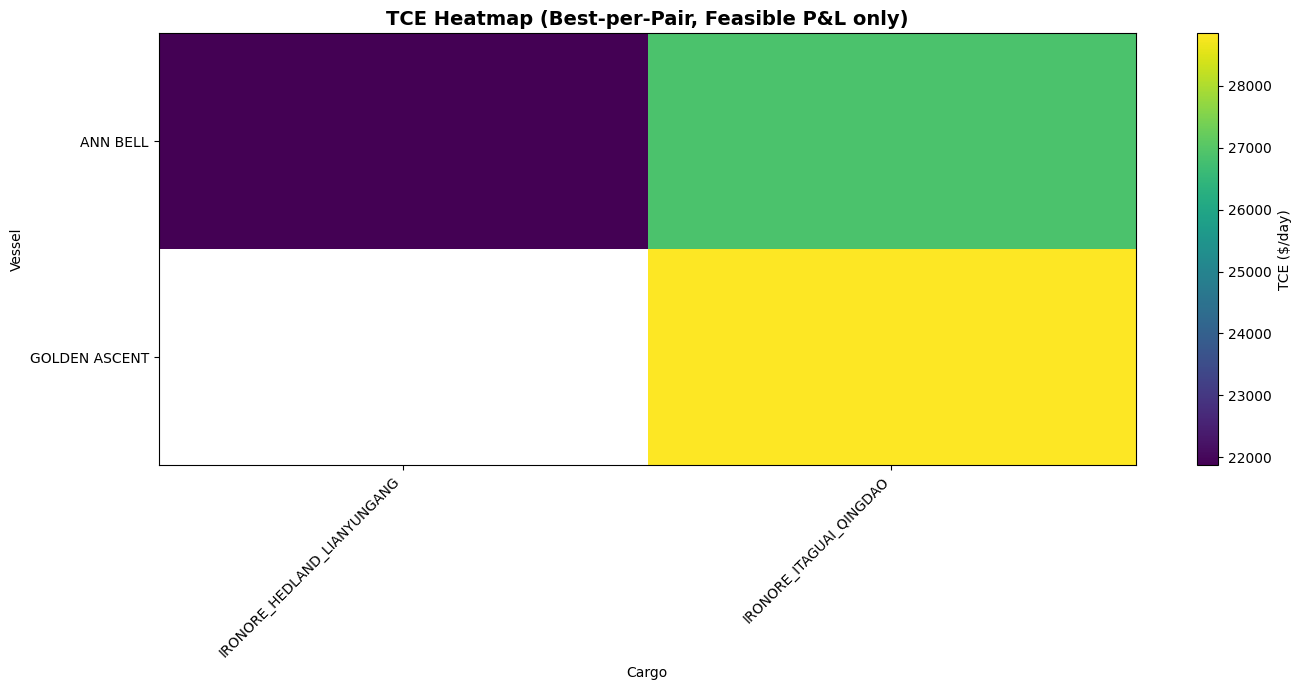

In [5]:
# -------------------------
# Calculate all vessel-cargo combinations
# -------------------------

all_vessels = get_all_vessels()   # 4 Cargill + 11 Market
all_cargoes = get_all_cargoes()   # 3 committed + 8 market

print(f"Analyzing {len(all_vessels)} vessels × {len(all_cargoes)} cargoes = {len(all_vessels) * len(all_cargoes)} vessel-cargo pairs")
print(f"  • Cargill vessels: {len(CARGILL_VESSELS)}")
print(f"  • Market vessels: {len(all_vessels) - len(CARGILL_VESSELS)}")
print(f"  • Committed cargoes: {len(CARGILL_CARGOES)}")
print(f"  • Market cargoes: {len(all_cargoes) - len(CARGILL_CARGOES)}")

# -------------------------
# A) RAW results (eco + war) for diagnostics + ML dataset
# -------------------------
raw_rows = []

for v in all_vessels:
    for c in all_cargoes:
        for use_eco in [True, False]:
            res_list = calc.evaluate_vessel_cargo(
                vessel=v,
                cargo=c,
                use_economical_speed=use_eco,
                use_rob=None,     # uses calculator default_use_rob
            )

            for r in res_list:
                rr = dict(r)
                rr["vessel_name"] = rr.get("vessel", v.get("name"))
                rr["cargo_name"] = rr.get("cargo", c.get("name"))
                rr["speed_mode"] = rr.get("speed_mode", "eco" if use_eco else "war")
                rr["vessel_current_port"] = v.get("current_port")
                rr["vessel_etd"] = v.get("etd")
                rr["cargo_load_port"] = c.get("load_port")
                rr["cargo_discharge_port"] = c.get("discharge_port")
                rr["cargo_laycan_start"] = c.get("laycan_start")
                rr["cargo_laycan_end"] = c.get("laycan_end")
                rr["route"] = f"{v.get('current_port')} -> {c.get('load_port')} -> {c.get('discharge_port')}"
                raw_rows.append(rr)

raw_df = pd.DataFrame(raw_rows)

print("\nRAW diagnostics")
print("Feasible rows:", int((raw_df.get("feasible") == True).sum()))
print("Feasible P&L rows:", int(((raw_df.get("feasible") == True) & (raw_df.get("mode") == "P&L")).sum()))

display(
    raw_df["feasible"].value_counts(dropna=False)
    .rename_axis("feasible")
    .reset_index(name="count")
)

if "issue" in raw_df.columns:
    print("\nTop infeasible issues:")
    display(
        raw_df.loc[raw_df["feasible"] == False, "issue"]
        .value_counts()
        .head(10)
        .rename_axis("issue")
        .reset_index(name="count")
    )

print("\nMode breakdown (feasible rows):")
if "mode" in raw_df.columns:
    display(
        raw_df.loc[raw_df["feasible"] == True, "mode"]
        .value_counts()
        .rename_axis("mode")
        .reset_index(name="count")
    )

# -------------------------
# B) BEST-per-pair table (1 row per vessel-cargo) for ranking + heatmap
# -------------------------
best_df = build_combinations_df(
    calc=calc,
    vessels=all_vessels,
    cargoes=all_cargoes,
    qty_label="base",
    try_both_speed_modes=True,
    use_rob=None,
)

print("\nBEST-per-pair table")
print("Rows (should equal vessel-cargo pairs):", len(best_df))
print("Feasible pairs:", int((best_df["feasible"] == True).sum()))

# -------------------------
# Top 5 by TCE (Base Case)
# -------------------------
pnl_base = best_df[
    (best_df["feasible"] == True) &
    (best_df["mode"] == "P&L")
].copy()

if len(pnl_base) == 0:
    print("\n⚠️ No feasible P&L pairs found, cannot rank by TCE yet.")
    print("Check raw_df issues above (most common are still missing_distance or missed_laycan).")
else:
    pnl_base["tce"] = pd.to_numeric(pnl_base["tce"], errors="coerce")
    pnl_base = pnl_base.dropna(subset=["tce"])

    print("\nTop 5 by TCE (feasible P&L only, qty=base, best speed chosen):")
    display(
        pnl_base.sort_values("tce", ascending=False).head(5)[[
            "vessel_name", "cargo_name", "speed_mode",
            "total_days", "tce", "voyage_profit",
            "net_revenue", "bunker_cost", "hire_cost", "port_cost",
            "ballast_nm", "laden_nm"
        ]]
    )

# -------------------------
# Heatmap: TCE matrix (BEST-per-pair)
# -------------------------
if len(pnl_base) > 0 and pnl_base["tce"].notna().any():
    pivot_tce = pnl_base.pivot(index="vessel_name", columns="cargo_name", values="tce")

    fig, ax = plt.subplots(figsize=(14, 7))
    data = pivot_tce.to_numpy(dtype=float)
    masked = np.ma.masked_invalid(data)

    im = ax.imshow(masked, aspect="auto")
    ax.set_title("TCE Heatmap (Best-per-Pair, Feasible P&L only)", fontsize=14, fontweight="bold")
    ax.set_xlabel("Cargo")
    ax.set_ylabel("Vessel")

    ax.set_xticks(np.arange(pivot_tce.shape[1]))
    ax.set_xticklabels(pivot_tce.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(pivot_tce.shape[0]))
    ax.set_yticklabels(pivot_tce.index)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("TCE ($/day)")

    plt.tight_layout()
    plt.show()
else:
    print("\n(No heatmap generated — no feasible P&L rows with valid TCE.)")


## 4. Optimal Allocation (Base Case)

In [8]:
# -------------------------
# Enrich Port_Distances with estimates (ONLY for missing pairs)
# -------------------------

def estimate_distance(from_port: str, to_port: str) -> float:
    regions = {
        "CHINA": ["QINGDAO", "DAGANG", "TIANJIN", "CAOFEIDIAN", "LIANYUNGANG", "FANGCHENG", "SHANGHAI", "JINGTANG", "XIAMEN"],
        "AUSTRALIA": ["PORT HEDLAND", "DAMPIER", "BRISBANE", "SYDNEY"],
        "BRAZIL": ["RIO DE JANEIRO", "SANTOS", "TUBARAO", "ITAGUAI", "PONTA DA MADEIRA"],
        "INDIA": ["VISAKHAPATNAM", "VIZAG", "PARADIP", "MUNDRA", "COCHIN", "KANDLA"],
        "WEST_AFRICA": ["KAMSAR", "CONAKRY", "GUINEA"],
        "MIDDLE_EAST": ["DUBAI", "JUBAIL", "FUJAIRAH"],
        "EUROPE": ["ROTTERDAM", "ANTWERP"],
        "SOUTHEAST_ASIA": ["SINGAPORE", "BALIKPAPAN", "LAEM CHABANG", "MAP TA PHUT", "TELUK RUBIAH"],
    }

    def region_of(p: str):
        p = str(p).upper()
        for r, keys in regions.items():
            if any(k in p for k in keys):
                return r
        return None

    fr = region_of(from_port)
    tr = region_of(to_port)

    # nm matrix (rough, but consistent)
    dm = {
        ("CHINA","WEST_AFRICA"): 10500,
        ("WEST_AFRICA","CHINA"): 10500,
        ("SOUTHEAST_ASIA","WEST_AFRICA"): 8500,
        ("WEST_AFRICA","SOUTHEAST_ASIA"): 8500,
        ("CHINA","SOUTHEAST_ASIA"): 1500,
        ("SOUTHEAST_ASIA","CHINA"): 1500,
        ("AUSTRALIA","CHINA"): 3700,
        ("CHINA","AUSTRALIA"): 3700,
        ("BRAZIL","CHINA"): 12000,
        ("CHINA","BRAZIL"): 12000,
        ("INDIA","CHINA"): 3500,
        ("CHINA","INDIA"): 3500,
    }

    if fr and tr:
        if fr == tr:
            return 500.0
        if (fr, tr) in dm:
            return float(dm[(fr, tr)])

    return 6000.0  # fallback


# Build required directed pairs for ALL vessel-cargo combos
all_vessels = get_all_vessels()
all_cargoes = get_all_cargoes()

needed_pairs = set()
for v in all_vessels:
    for c in all_cargoes:
        needed_pairs.add((str(v["current_port"]).upper().strip(), str(c["load_port"]).upper().strip()))
        needed_pairs.add((str(c["load_port"]).upper().strip(), str(c["discharge_port"]).upper().strip()))

# Existing directed pairs in the CSV
d0 = distances.copy()
d0["A"] = d0["PORT_NAME_FROM"].astype(str).str.upper().str.strip()
d0["B"] = d0["PORT_NAME_TO"].astype(str).str.upper().str.strip()
existing = set(zip(d0["A"], d0["B"]))

# Add missing
new_rows = []
for a, b in sorted(list(needed_pairs)):
    if (a, b) not in existing:
        new_rows.append({"PORT_NAME_FROM": a, "PORT_NAME_TO": b, "DISTANCE": estimate_distance(a, b), "is_estimate": 1})

if new_rows:
    distances_enriched = pd.concat([distances, pd.DataFrame(new_rows)], ignore_index=True)
else:
    distances_enriched = distances.copy()

print(f"Added {len(new_rows)} estimated directed distance rows.")

# Re-init calculator with enriched distances
calc = FreightCalculator(distances_enriched, bunker_prices)


Added 130 estimated directed distance rows.



OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE — COMMITTED)


,vessel_name,cargo_name,mode,speed_mode,total_days,tce,voyage_profit,net_revenue,total_costs,hire_cost,bunker_cost,port_cost,ballast_nm,laden_nm
0,ANN BELL,IRONORE_HEDLAND_LIANYUNGANG,P&L,eco,33.48,21008.09,309937.67,1386000.00,1076062.33,393360.62,302701.71,380000.00,3700.00,3545.52
1,OCEAN HORIZON,IRONORE_ITAGUAI_QINGDAO,P&L,eco,79.77,33056.72,1380548.86,3863475.00,2482926.14,1256369.82,1061556.32,165000.00,6000.00,11370.96
2,PACIFIC GLORY,BAUXITE_KAMSAR_QINGDAO,P&L,eco,73.06,45087.96,2212858.33,4088250.00,1875391.67,1081297.70,794093.97,0.00,6000.00,10500.00



TOTAL PORTFOLIO PROFIT (committed): $3,903,344.86
Unused vessels: GOLDEN ASCENT


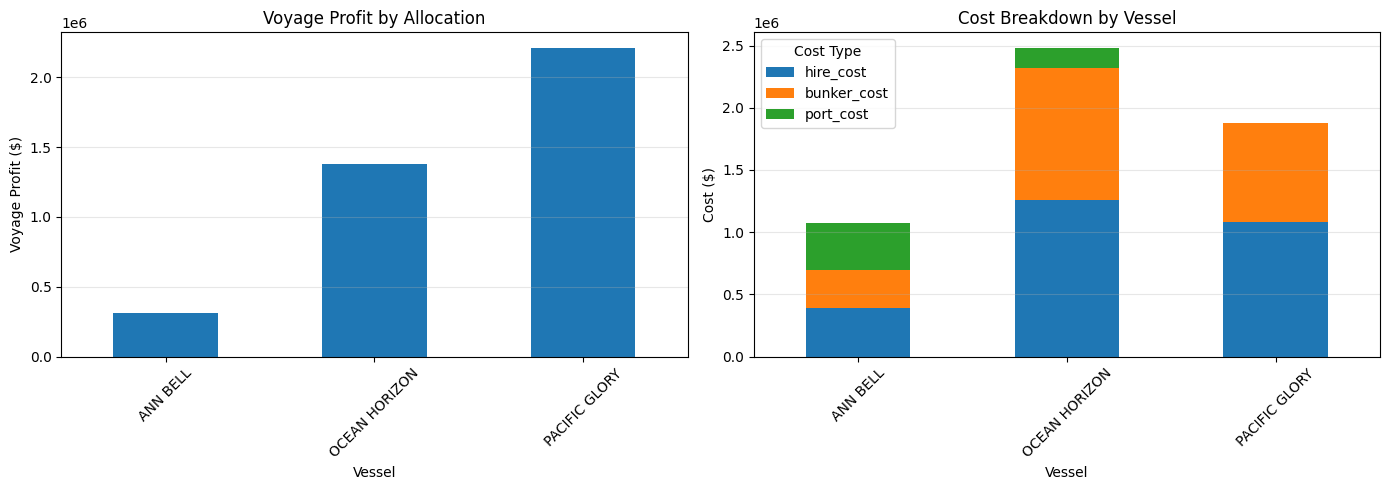

In [9]:
# -------------------------
# Optimal Allocation (Base Case - Committed)
# -------------------------

opt = calc.optimize_committed_cargo_assignment(
    vessels=CARGILL_VESSELS,
    committed_cargoes=CARGILL_CARGOES,
    qty_label="base",
    try_both_speed_modes=True,
    use_rob=None,
)

print("\n" + "="*80)
print("OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE — COMMITTED)")
print("="*80)

if not opt.get("feasible"):
    print("✗ No feasible committed assignment found.")
    print("Reason:", opt.get("issue"))

    # Helpful debug table: best-per-pair for committed only
    committed_pairs = build_combinations_df(
        calc,
        vessels=CARGILL_VESSELS,
        cargoes=CARGILL_CARGOES,
        qty_label="base",
        try_both_speed_modes=True,
        use_rob=None,
    )
    display(committed_pairs.sort_values(["cargo", "vessel"]))
else:
    # Flatten assignments
    rows = []
    for a in opt["assignments"]:
        r = a["result"]
        rows.append({
            "vessel_name": a["vessel"],
            "cargo_name": a["cargo"],
            "mode": a.get("mode"),
            "speed_mode": r.get("speed_mode"),
            "total_days": r.get("total_days"),
            "tce": r.get("tce"),
            "voyage_profit": r.get("voyage_profit"),
            "net_revenue": r.get("net_revenue"),
            "total_costs": r.get("total_costs"),
            "hire_cost": r.get("hire_cost"),
            "bunker_cost": r.get("bunker_cost"),
            "port_cost": r.get("port_cost"),
            "ballast_nm": r.get("ballast_nm"),
            "laden_nm": r.get("laden_nm"),
        })

    allocation_df = pd.DataFrame(rows)

    display(allocation_df)
    print(f"\nTOTAL PORTFOLIO PROFIT (committed): ${opt['total_profit']:,.2f}")
    print(f"Unused vessels: {', '.join(opt.get('unused_vessels', []))}")

    # Visuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax1 = axes[0]
    allocation_df.plot(x="vessel_name", y="voyage_profit", kind="bar", ax=ax1, legend=False)
    ax1.set_title("Voyage Profit by Allocation")
    ax1.set_xlabel("Vessel")
    ax1.set_ylabel("Voyage Profit ($)")
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(axis="y", alpha=0.3)

    ax2 = axes[1]
    cost_data = allocation_df[["vessel_name", "hire_cost", "bunker_cost", "port_cost"]].set_index("vessel_name")
    cost_data.plot(kind="bar", stacked=True, ax=ax2)
    ax2.set_title("Cost Breakdown by Vessel")
    ax2.set_xlabel("Vessel")
    ax2.set_ylabel("Cost ($)")
    ax2.tick_params(axis="x", rotation=45)
    ax2.legend(title="Cost Type")
    ax2.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


## 5. Machine Learning: Risk Simulation

We use Random Forest to simulate shipping risks (weather delays, port congestion) and their impact on voyage profitability.

In [ ]:
# Prepare ML features with domain knowledge
ml_df = results_df.copy()

# Import additional dependencies
from vessel_cargo_data import get_all_vessels

# ========================================
# Geographic Risk Features
# ========================================

# China ports known for congestion
ml_df['discharge_china'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['QINGDAO', 'CAOFEIDIAN',
                                                        'LIANYUNGANG', 'TIANJIN',
                                                        'FANGCHENG', 'SHANGHAI']) else 0
)

# Brazil/South America loading (weather-dependent)
ml_df['load_south_america'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['ITAGUAI', 'TUBARAO',
                                                        'MADEIRA', 'PONTAMADEIRA']) else 0
)

# West Africa anchorage loading (high variability)
ml_df['load_west_africa'] = ml_df['cargo_name'].apply(
    lambda x: 1 if 'KAMSAR' in str(x).upper() or 'CONAKRY' in str(x).upper() else 0
)

# Australia (generally efficient)
ml_df['load_australia'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['HEDLAND', 'DAMPIER']) else 0
)

# ========================================
# Route Risk Features
# ========================================

# Total route distance (longer = more weather exposure)
ml_df['route_length_nm'] = ml_df['ballast_distance'] + ml_df['laden_distance']

# Ballast positioning risk (longer ballast = more exposure before earning)
ml_df['ballast_ratio'] = ml_df['ballast_distance'] / ml_df['route_length_nm']

# ========================================
# Seasonal Risk Features
# ========================================

# Extract month from laycan
ml_df['laycan_month'] = pd.to_datetime(
    ml_df['cargo_laycan'].str.split(' to ').str[0]
).dt.month

# Cyclone/typhoon season in Asia (June-Nov)
ml_df['cyclone_season'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [6, 7, 8, 9, 10, 11] else 0
)

# Winter monsoon in Asia (Dec-Feb)
ml_df['winter_monsoon'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [12, 1, 2] else 0
)

# ========================================
# Economic/Operational Features
# ========================================

# Bunker cost as % of revenue (high = more fuel price risk)
ml_df['bunker_cost_ratio'] = ml_df['bunker_cost'] / ml_df['net_revenue']

# Hire cost as % of revenue (high = less profitable margin)
ml_df['hire_cost_ratio'] = ml_df['hire_cost'] / ml_df['net_revenue']

# Port cost as % of revenue
ml_df['port_cost_ratio'] = ml_df['port_cost'] / (ml_df['net_revenue'] + 1)  # +1 to avoid division by zero

# Days at sea vs days in port (efficiency indicator)
ml_df['sea_port_ratio'] = ml_df['sea_days'] / (ml_df['port_days'] + 0.1)  # +0.1 to avoid division by zero

# TCE margin (higher = better deal, more buffer for risks)
ml_df['tce_margin'] = ml_df['tce'] / 10000  # Normalized

# ========================================
# Cargo-Specific Risks
# ========================================

# Iron ore (most common, well-established terminals)
ml_df['cargo_iron_ore'] = ml_df['cargo_name'].str.contains('IRON', case=False, na=False).astype(int)

# Bauxite (often smaller/remote ports, anchorage loading)
ml_df['cargo_bauxite'] = ml_df['cargo_name'].str.contains('BAUXITE', case=False, na=False).astype(int)

# Coal (dust concerns, environmental restrictions in some ports)
ml_df['cargo_coal'] = ml_df['cargo_name'].str.contains('COAL', case=False, na=False).astype(int)

# ========================================
# Vessel-Specific Risks
# ========================================

# Vessel bunker remaining (vessels with more bunker may be newer/better maintained)
vessel_bunker_map = {v['name']: v['bunker_vlsf'] for v in get_all_vessels()}
ml_df['vessel_bunker_ratio'] = ml_df['vessel_name'].map(vessel_bunker_map) / 600  # Normalize

# ========================================
# Domain-Based Risk Simulation
# ========================================

def calculate_weather_risk_days(row):
    """
    Estimate weather delays based on route and season
    """
    base_risk = 0
    
    # Route distance factor (exponential: longer routes = disproportionately more risk)
    distance_factor = (row['route_length_nm'] / 8000) ** 1.2
    base_risk += distance_factor * 0.5
    
    # Cyclone season
    if row['cyclone_season'] == 1:
        base_risk += 1.5
    
    # Winter monsoon
    if row['winter_monsoon'] == 1:
        base_risk += 0.8
    
    # South America weather (summer storms)
    if row['load_south_america'] == 1:
        base_risk += 1.0
    
    # Long Pacific crossings (more weather windows)
    if row['route_length_nm'] > 12000:
        base_risk += 1.2
    
    return max(0, base_risk + np.random.normal(0, 0.5))  # Add small random variation

def calculate_port_congestion_days(row):
    """
    Estimate port delays based on terminal characteristics
    """
    congestion = 0
    
    # China ports (known congestion issues)
    if row['discharge_china'] == 1:
        congestion += 2.5  # Average 2-3 days
    
    # West Africa anchorage loading (weather dependent)
    if row['load_west_africa'] == 1:
        congestion += 1.5
    
    # Iron ore cargoes (high volume, but efficient terminals)
    if row['cargo_iron_ore'] == 1:
        congestion += 0.5
    
    # Bauxite (smaller terminals, less efficient)
    if row['cargo_bauxite'] == 1:
        congestion += 1.0
    
    # Seasonal factor (March-April = higher traffic in some regions)
    if row['laycan_month'] in [3, 4]:
        congestion += 0.5
    
    return max(0, congestion + np.random.gamma(1.5, 0.5))  # Gamma distribution (right-skewed)

def calculate_mechanical_risk(row):
    """
    Binary risk: does voyage experience mechanical delay?
    """
    # Base probability
    base_prob = 0.08  # 8% of voyages
    
    # Increase for very long voyages (more exposure time)
    if row['route_length_nm'] > 15000:
        base_prob += 0.03
    
    # Older vessels (lower bunker = proxy for age)
    if row['vessel_bunker_ratio'] < 0.5:
        base_prob += 0.02
    
    return np.random.binomial(1, base_prob)

# Apply risk calculations
np.random.seed(42)
ml_df['weather_risk_days'] = ml_df.apply(calculate_weather_risk_days, axis=1)
ml_df['port_congestion_days'] = ml_df.apply(calculate_port_congestion_days, axis=1)
ml_df['mechanical_risk'] = ml_df.apply(calculate_mechanical_risk, axis=1)

# Mechanical delay adds 2-5 days if it occurs
ml_df['mechanical_delay_days'] = ml_df['mechanical_risk'] * np.random.uniform(2, 5, len(ml_df))

# ========================================
# Calculate Risk-Adjusted Metrics
# ========================================

ml_df['total_risk_days'] = (
    ml_df['weather_risk_days'] +
    ml_df['port_congestion_days'] +
    ml_df['mechanical_delay_days']
)

ml_df['risk_adjusted_days'] = ml_df['total_days'] + ml_df['total_risk_days']

# Risk-adjusted profit (additional days = additional hire cost)
vessel_hire_map = {v['name']: v['hire_rate'] for v in get_all_vessels()}
ml_df['vessel_hire_rate'] = ml_df['vessel_name'].map(vessel_hire_map)

ml_df['risk_adjusted_hire_cost'] = ml_df['vessel_hire_rate'] * ml_df['risk_adjusted_days']

ml_df['risk_adjusted_total_cost'] = (
    ml_df['risk_adjusted_hire_cost'] +
    ml_df['bunker_cost'] +
    ml_df['port_cost']
)

ml_df['risk_adjusted_profit'] = ml_df['net_revenue'] - ml_df['risk_adjusted_total_cost']

ml_df['risk_adjusted_tce'] = (
    (ml_df['net_revenue'] - ml_df['bunker_cost'] - ml_df['port_cost']) /
    ml_df['risk_adjusted_days']
)

print("✓ Domain-driven features created")
print(f"\n📊 Risk Analysis Summary:")
print(f"Average weather delay: {ml_df['weather_risk_days'].mean():.2f} days")
print(f"Average port congestion: {ml_df['port_congestion_days'].mean():.2f} days")
print(f"Mechanical issues: {ml_df['mechanical_risk'].sum()} of {len(ml_df)} voyages ({ml_df['mechanical_risk'].mean()*100:.1f}%)")
print(f"Average total risk: {ml_df['total_risk_days'].mean():.2f} days")
print(f"\n💰 Financial Impact:")
print(f"Base case profit: ${ml_df['voyage_profit'].sum():,.0f}")
print(f"Risk-adjusted profit: ${ml_df['risk_adjusted_profit'].sum():,.0f}")
print(f"Expected loss from risks: ${(ml_df['voyage_profit'].sum() - ml_df['risk_adjusted_profit'].sum()):,.0f}")

In [ ]:
# Train multiple ML models to predict risk-adjusted TCE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Feature selection for ML
feature_cols = [
    # Geographic
    'discharge_china', 'load_south_america', 'load_west_africa', 'load_australia',
    # Route
    'route_length_nm', 'ballast_ratio',
    # Seasonal
    'cyclone_season', 'winter_monsoon',
    # Economic
    'bunker_cost_ratio', 'hire_cost_ratio', 'tce_margin',
    # Cargo/Vessel
    'cargo_iron_ore', 'cargo_bauxite', 'vessel_bunker_ratio'
]

# Prepare data with proper cleaning
X = ml_df[feature_cols].copy()
y = ml_df['risk_adjusted_tce'].copy()

# ========================================
# Data Validation and Cleaning
# ========================================
print("🔍 Data Quality Check:")
print(f"Initial dataset size: {len(X)} samples")

# Check for NaN in features
nan_in_X = X.isnull().sum().sum()
print(f"NaN values in features: {nan_in_X}")

# Check for NaN in target
nan_in_y = y.isnull().sum()
print(f"NaN values in target: {nan_in_y}")

# Check for infinite values
inf_in_X = np.isinf(X).sum().sum()
inf_in_y = np.isinf(y).sum()
print(f"Inf values in features: {inf_in_X}")
print(f"Inf values in target: {inf_in_y}")

# Clean the data
# Replace inf with NaN first
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Fill NaN in features with 0 (conservative approach)
X = X.fillna(0)

# Remove rows where target is NaN or inf
valid_indices = y.notna()
X_clean = X[valid_indices]
y_clean = y[valid_indices]

print(f"\n✓ Clean dataset size: {len(X_clean)} samples")
print(f"✓ Removed {len(X) - len(X_clean)} samples with invalid target values")

# Use cleaned data for all subsequent analysis
X = X_clean
y = y_clean

# ========================================
# Train Multiple Models
# ========================================
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=8,
        min_samples_split=5,
        random_state=42
    )
}

# Train and evaluate
model_results = []

for name, model in models.items():
    # Train
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Evaluate
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    model_results.append({
        'Model': name,
        'R² Score': r2,
        'MAE ($)': mae,
        'RMSE ($)': rmse,
        'Complexity': 'High' if name in ['Random Forest', 'Gradient Boosting'] else
                      'Medium' if name == 'Decision Tree' else 'Low'
    })

results_df_models = pd.DataFrame(model_results).sort_values('R² Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON: Risk-Adjusted TCE Prediction")
print("="*80)
display(results_df_models)

# Select best model
best_model_name = results_df_models.iloc[0]['Model']
best_model = models[best_model_name]

# Add predictions to ml_df (for valid rows only)
ml_df['predicted_tce'] = np.nan  # Initialize with NaN
ml_df.loc[valid_indices, 'predicted_tce'] = best_model.predict(X)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score: {results_df_models.iloc[0]['R² Score']:.4f}")
print(f"   MAE: ${results_df_models.iloc[0]['MAE ($)']:,.0f}/day")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
results_df_models.plot(
    x='Model',
    y='R² Score',
    kind='barh',
    ax=ax1,
    color='skyblue',
    legend=False
)
ax1.set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('R² Score (higher is better)', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# MAE comparison
ax2 = axes[1]
results_df_models.plot(
    x='Model',
    y='MAE ($)',
    kind='barh',
    ax=ax2,
    color='coral',
    legend=False
)
ax2.set_title('Model Performance: Mean Absolute Error', fontsize=12, fontweight='bold')
ax2.set_xlabel('MAE in $/day (lower is better)', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Enhanced Feature Importance Analysis
model = best_model

# ========================================
# 1. Standard Feature Importance
# ========================================
if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    display(feature_importance)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_title('Feature Importance for Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    # For linear models, show coefficients
    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*80)
    print("MODEL COEFFICIENTS")
    print("="*80)
    display(coefficients)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
    ax.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
    ax.set_xlabel('Coefficient Value', fontsize=12)
    ax.set_title('Feature Coefficients (Positive = Increases TCE)', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# ========================================
# 2. Interpretation Summary
# ========================================
print("\n" + "="*80)
print("KEY INSIGHTS FROM ML ANALYSIS")
print("="*80)

if hasattr(model, 'feature_importances_'):
    top_5 = feature_importance.head(5)['Feature'].tolist()
else:
    top_5 = coefficients.head(5)['Feature'].tolist()

print("\n🔍 Most Important Risk Factors:")
feature_descriptions = {
    'route_length_nm': 'Longer routes increase weather exposure and operational risk',
    'discharge_china': 'China ports have known congestion, adding 2-3 days average delay',
    'bunker_cost_ratio': 'High fuel costs reduce profit margins and increase price risk',
    'tce_margin': 'Higher base TCE provides buffer to absorb unexpected costs',
    'cyclone_season': 'Seasonal weather patterns significantly impact voyage reliability',
    'load_south_america': 'Brazil loading faces weather variability and port efficiency issues',
    'ballast_ratio': 'Long ballast legs reduce earning efficiency and increase positioning costs',
    'hire_cost_ratio': 'High hire relative to revenue indicates thin profit margins',
    'load_west_africa': 'West Africa anchorage loading adds operational complexity',
    'cargo_bauxite': 'Bauxite terminals tend to be smaller and less efficient',
    'cargo_iron_ore': 'Iron ore benefits from well-established, efficient terminals',
    'vessel_bunker_ratio': 'Vessel bunker levels may indicate vessel age/condition',
    'winter_monsoon': 'Winter monsoon season affects routes in Asian waters',
    'load_australia': 'Australian ports generally have efficient loading operations'
}

for i, feature in enumerate(top_5, 1):
    description = feature_descriptions.get(feature, 'Impacts voyage profitability')
    print(f"   {i}. {feature}: {description}")

print("\n💡 Commercial Recommendations:")
print("   • Prioritize shorter routes during cyclone season (Jun-Nov)")
print("   • Build in 2-3 day buffer for China discharge ports")
print("   • Consider bunker hedging for voyages with high fuel cost exposure")
print("   • West Africa loadings need flexible scheduling and weather contingencies")
print("   • Monitor vessel-specific risk factors (age, condition, bunker levels)")

In [ ]:
# Enhanced SHAP Analysis for Model Interpretability

# Only run SHAP for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # ========================================
    # 1. SHAP Summary Plot
    # ========================================
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)
    
    # Summary plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, show=False)
    plt.title('SHAP Analysis: Feature Impact on Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Bar plot (mean absolute SHAP values)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 2. SHAP Dependence Plots (Top 3 Features)
    # ========================================
    if hasattr(model, 'feature_importances_'):
        top_3_features = feature_importance.head(3)['Feature'].tolist()
    else:
        top_3_features = feature_cols[:3]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, feature in enumerate(top_3_features):
        feature_idx = feature_cols.index(feature)
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X,
            feature_names=feature_cols,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("SHAP INTERPRETATION")
    print("="*80)
    print("\n📊 What the plots show:")
    print("   • Beeswarm plot: Each dot is a voyage. Red = high feature value, blue = low")
    print("   • Positive SHAP = increases TCE, negative SHAP = decreases TCE")
    print("   • Spread shows how much the feature impacts different voyages")
    print("\n   • Dependence plots show how feature values affect predictions")
    print("   • Color in dependence plots shows interaction with most correlated feature")
    
else:
    print("\n" + "="*80)
    print("SHAP Analysis")
    print("="*80)
    print(f"\nSHAP analysis is most informative for tree-based models.")
    print(f"Current model ({best_model_name}) is linear - see coefficient plot above instead.")
    print(f"\nCoefficients directly show feature impact:")
    print(f"   • Positive coefficient = feature increases TCE")
    print(f"   • Negative coefficient = feature decreases TCE")
    print(f"   • Magnitude = strength of impact")

In [ ]:
# Compare Base Case vs Risk-Adjusted Allocations

# Find optimal allocation using risk-adjusted metrics
# Create a copy of ml_df with risk-adjusted values replacing base values
ml_df_risk = ml_df.copy()
ml_df_risk['tce'] = ml_df_risk['risk_adjusted_tce']
ml_df_risk['voyage_profit'] = ml_df_risk['risk_adjusted_profit']
ml_df_risk['total_days'] = ml_df_risk['risk_adjusted_days']

# Find optimal allocation with risk-adjusted metrics
from vessel_cargo_data import CARGILL_CARGOES, get_all_vessels
optimal_risk_adjusted = find_optimal_allocation(
    ml_df_risk,
    num_vessels=len(get_all_vessels()),
    num_cargoes=len(CARGILL_CARGOES)
)

# Compare base case vs risk-adjusted
comparison = []

base_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal['allocation']}
risk_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal_risk_adjusted['allocation']}

# Get all vessels from both allocations
all_allocated_vessels = set(base_allocations.keys()) | set(risk_allocations.keys())

for vessel in all_allocated_vessels:
    base_cargo = base_allocations.get(vessel, 'Unallocated')
    risk_cargo = risk_allocations.get(vessel, 'Unallocated')
    
    changed = '✓ CHANGED' if base_cargo != risk_cargo else 'Same'
    
    comparison.append({
        'Vessel': vessel,
        'Base Case Cargo': base_cargo,
        'Risk-Adjusted Cargo': risk_cargo,
        'Status': changed
    })

comparison_df = pd.DataFrame(comparison)

print("\n" + "="*80)
print("ALLOCATION COMPARISON: Base Case vs Risk-Adjusted")
print("="*80)
display(comparison_df)

print(f"\n💰 Profit Comparison:")
print(f"   Base Case Profit: ${optimal['total_profit']:,.0f}")
print(f"   Risk-Adjusted Profit: ${optimal_risk_adjusted['total_profit']:,.0f}")
profit_diff = optimal['total_profit'] - optimal_risk_adjusted['total_profit']
print(f"   Difference: ${abs(profit_diff):,.0f} ({'higher' if profit_diff > 0 else 'lower'} in base case)")

# Check if allocations are the same
num_changed = comparison_df[comparison_df['Status'] == '✓ CHANGED'].shape[0]

if num_changed == 0:
    print("\n✅ ML risk analysis confirms our base allocation is robust to risk factors!")
    print("   The same vessel-cargo pairings remain optimal even after accounting for:")
    print("   • Weather delays (avg {:.1f} days)".format(ml_df['weather_risk_days'].mean()))
    print("   • Port congestion (avg {:.1f} days)".format(ml_df['port_congestion_days'].mean()))
    print("   • Mechanical risks ({:.1f}% probability)".format(ml_df['mechanical_risk'].mean()*100))
else:
    print(f"\n⚠️ Risk analysis suggests {num_changed} allocation change(s):")
    changes = comparison_df[comparison_df['Status'] == '✓ CHANGED']
    for _, row in changes.iterrows():
        print(f"   • {row['Vessel']}: {row['Base Case Cargo']} → {row['Risk-Adjusted Cargo']}")
    print("\n   Recommendation: Consider both allocations in your report.")
    print("   • Base case: Maximizes theoretical profit")
    print("   • Risk-adjusted: More robust to operational uncertainties")

# Visualize profit comparison
fig, ax = plt.subplots(figsize=(10, 6))

allocation_comparison_data = pd.DataFrame({
    'Allocation': ['Base Case', 'Risk-Adjusted'],
    'Profit ($M)': [optimal['total_profit'] / 1e6, optimal_risk_adjusted['total_profit'] / 1e6]
})

bars = ax.bar(allocation_comparison_data['Allocation'], allocation_comparison_data['Profit ($M)'],
              color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}M',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
ax.set_title('Profit Comparison: Base Case vs Risk-Adjusted Allocation', fontsize=14, fontweight='bold')
ax.set_ylim(0, allocation_comparison_data['Profit ($M)'].max() * 1.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Allocation Comparison: Base Case vs Risk-Adjusted

How does incorporating risk analysis change our optimal allocation recommendations?

In [ ]:
# Cross-Validation for Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)
print(f"Dataset size: {len(X)} samples")
print(f"Using 10-Fold Cross-Validation for robust validation\n")

# Use 10-Fold CV instead of LOO (LOO with R² scoring produces NaN because
# R² requires more than 1 sample to compute variance)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = []

for name, model_template in models.items():
    # Clone the model to get a fresh unfitted estimator
    model_cv = clone(model_template)

    # Perform cross-validation with R² scoring
    r2_scores = cross_val_score(
        model_cv, X, y,
        cv=kfold,
        scoring='r2',
        n_jobs=-1
    )

    # Also compute MAE for additional insight
    model_cv_mae = clone(model_template)
    mae_scores = cross_val_score(
        model_cv_mae, X, y,
        cv=kfold,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    cv_results.append({
        'Model': name,
        'Mean R²': r2_scores.mean(),
        'Std R²': r2_scores.std(),
        'Min R²': r2_scores.min(),
        'Max R²': r2_scores.max(),
        'Mean MAE ($)': -mae_scores.mean()  # Negate because sklearn returns negative MAE
    })

cv_df = pd.DataFrame(cv_results).sort_values('Mean R²', ascending=False)
display(cv_df)

print(f"\n📊 Interpretation:")
print(f"   • Mean R² shows average prediction accuracy across all 10 folds")
print(f"   • Low Std R² indicates consistent performance across different samples")
print(f"   • Large range (Max - Min) suggests some voyages are harder to predict")
print(f"   • Negative R² indicates worse than baseline prediction (very poor)")
print(f"   • MAE shows average prediction error in $/day")

# Save predictions with confidence
ml_df['ml_predicted_tce'] = best_model.predict(X)
ml_df['prediction_error'] = abs(ml_df['ml_predicted_tce'] - ml_df['risk_adjusted_tce'])

print(f"\n🎯 Prediction Accuracy ({best_model_name}):")
print(f"   • Mean Absolute Error: ${ml_df['prediction_error'].mean():,.0f}/day")
print(f"   • Median Absolute Error: ${ml_df['prediction_error'].median():,.0f}/day")
print(f"   • 90th Percentile Error: ${ml_df['prediction_error'].quantile(0.9):,.0f}/day")
print(f"\n   This means: 90% of predictions are within ${ml_df['prediction_error'].quantile(0.9):,.0f}/day of actual")

### Cross-Validation Analysis

Given the dataset size (165 combinations), we use 10-Fold Cross-Validation to ensure our model generalizes well. This provides a robust estimate of model performance while avoiding numerical issues that can occur with Leave-One-Out CV and R² scoring.

## 6. Scenario Analysis

### Scenario 1: Port Delay in China
Find the number of additional port delay days that would make the current recommendation no longer optimal.

In [ ]:
# Define list of China ports for scenario analysis
CHINA_PORTS = ['QINGDAO', 'LIANYUNGANG', 'CAOFEIDIAN', 'TIANJIN', 'FANGCHENG', 
               'SHANGHAI', 'NINGBO', 'JINGTANG', 'RIZHAO', 'DALIAN']

def test_port_delay_scenario(base_allocation, delay_days):
    """
    Test how port delays in China affect profitability
    """
    results = []
    
    # Get full vessel and cargo lists (not just Cargill)
    all_vessels_list = get_all_vessels()
    all_cargoes_list = get_all_cargoes()
    
    for row in base_allocation:
        vessel = next(v for v in all_vessels_list if v['name'] == row['vessel_name'])
        cargo = next(c for c in all_cargoes_list if c['name'] == row['cargo_name'])
        
        # Check if discharge port is in China (expanded list)
        discharge_port = cargo['discharge_port'].upper()
        is_china = any(china_port in discharge_port for china_port in CHINA_PORTS)
        
        # Recalculate with delay
        adjusted_days = row['total_days'] + (delay_days if is_china else 0)
        adjusted_hire = vessel['hire_rate'] * adjusted_days
        adjusted_total_cost = adjusted_hire + row['bunker_cost'] + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - row['bunker_cost'] - row['port_cost']) / adjusted_days
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'discharge_port': cargo['discharge_port'],
            'china_port': is_china,
            'delay_days': delay_days,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'original_tce': row['tce'],
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different delay scenarios
delay_scenarios = [0, 2, 4, 6, 8, 10, 12, 15]
scenario_results = []

for delay in delay_scenarios:
    result = test_port_delay_scenario(optimal['allocation'], delay)
    total_profit = result['adjusted_profit'].sum()
    china_affected = result[result['china_port'] == True]
    scenario_results.append({
        'delay_days': delay,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit,
        'voyages_affected': len(china_affected)
    })

scenario_df = pd.DataFrame(scenario_results)

print("\nSCENARIO 1: PORT DELAY IN CHINA")
print("="*80)

# Show which voyages go to China
detail_result = test_port_delay_scenario(optimal['allocation'], 0)
china_voyages = detail_result[detail_result['china_port'] == True]
non_china_voyages = detail_result[detail_result['china_port'] == False]

print(f"\n📍 Voyages discharging in China ({len(china_voyages)} of {len(detail_result)}):")
for _, row in china_voyages.iterrows():
    print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

if len(non_china_voyages) > 0:
    print(f"\n📍 Voyages NOT discharging in China ({len(non_china_voyages)}):")
    for _, row in non_china_voyages.iterrows():
        print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

print("\n" + "-"*80)
display(scenario_df)

In [ ]:
# Find threshold
# When does the profit drop below the next best alternative?
all_combos_sorted = results_df.sort_values('voyage_profit', ascending=False)
second_best_profit = all_combos_sorted.iloc[3]['voyage_profit']  # 4th best (after top 3 allocations)

threshold_days = scenario_df[scenario_df['total_profit'] < (optimal['total_profit'] - 500000)]['delay_days'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_days):
    threshold_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"At {threshold_days} days of port delay in China, portfolio profit drops to ${threshold_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${threshold_row['profit_loss']:,.0f}")
else:
    # No scenario drops profit by $500K+
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"Even at maximum tested delay ({max_delay} days), profit only drops to ${max_delay_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${max_delay_row['profit_loss']:,.0f} ({max_delay_row['profit_loss']/optimal['total_profit']*100:.1f}% reduction)")
    print(f"The allocation remains profitable under all tested delay scenarios.")

In [ ]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(scenario_df['delay_days'], scenario_df['total_profit'] / 1e6, marker='o', linewidth=2, color='navy')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.xlabel('Port Delay in China (days)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 1: Impact of Port Delays in China', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Scenario 2: Bunker Price Increase
Identify the fuel price increase (%) at which the current recommendation becomes less profitable.

In [ ]:
def test_bunker_price_scenario(base_allocation, price_increase_pct):
    """
    Test how bunker price increases affect profitability
    """
    results = []
    
    for row in base_allocation:
        # Increase bunker cost
        multiplier = 1 + (price_increase_pct / 100)
        adjusted_bunker = row['bunker_cost'] * multiplier
        adjusted_total_cost = row['hire_cost'] + adjusted_bunker + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - adjusted_bunker - row['port_cost']) / row['total_days']
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'price_increase': price_increase_pct,
            'original_bunker_cost': row['bunker_cost'],
            'adjusted_bunker_cost': adjusted_bunker,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different price increase scenarios
price_scenarios = [0, 5, 10, 15, 20, 25, 30, 40, 50]
price_results = []

for pct in price_scenarios:
    result = test_bunker_price_scenario(optimal['allocation'], pct)
    total_profit = result['adjusted_profit'].sum()
    price_results.append({
        'price_increase_pct': pct,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit
    })

price_df = pd.DataFrame(price_results)

print("\nSCENARIO 2: BUNKER PRICE INCREASE")
print("="*80)
display(price_df)

In [ ]:
# Find threshold for recommendation change
threshold_pct = price_df[price_df['total_profit'] < (optimal['total_profit'] * 0.8)]['price_increase_pct'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_pct):
    threshold_pct_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"At {threshold_pct}% bunker price increase, portfolio profit drops to ${threshold_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(threshold_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"\n⚠️ RECOMMENDATION: Monitor bunker prices closely. Above {threshold_pct}% increase, consider alternative vessel-cargo pairings.")
else:
    # No scenario drops profit below 80%
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    print(f"Even at maximum tested increase ({max_pct}%), profit only drops to ${max_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(max_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"The allocation remains robust under all tested bunker price scenarios.")

In [ ]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(price_df['price_increase_pct'], price_df['total_profit'] / 1e6, marker='s', linewidth=2, color='darkred')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.axhline((optimal['total_profit'] * 0.8) / 1e6, color='red', linestyle=':', label='80% of Base Profit', alpha=0.7)
plt.xlabel('Bunker Price Increase (%)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 2: Impact of Bunker Price Increases', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Key Findings & Recommendations

In [ ]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. OPTIMAL ALLOCATION:")
for i, row in enumerate(optimal['allocation'], 1):
    print(f"   {i}. {row['vessel_name']} → {row['cargo_name']}")
    print(f"      TCE: ${row['tce']:,.0f}/day | Profit: ${row['voyage_profit']:,.0f}")

print(f"\n   Total Portfolio Profit: ${optimal['total_profit']:,.0f}")
print(f"   Unallocated: {', '.join(optimal['unallocated_vessels'])}")

print("\n2. RISK FACTORS:")
print(f"   • Weather delays add avg {ml_df['weather_risk_days'].mean():.1f} days")
print(f"   • Port congestion adds avg {ml_df['port_congestion_days'].mean():.1f} days")
print(f"   • Route length is the most important risk factor")

print("\n3. SCENARIO THRESHOLDS:")

# Port delay threshold
if pd.notna(threshold_days):
    threshold_delay_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"   • Port delays: {threshold_days} days in China ports reduce profit by ${threshold_delay_row['profit_loss']:,.0f}")
else:
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"   • Port delays: Allocation robust up to {max_delay} days (max loss: ${max_delay_row['profit_loss']:,.0f})")

# Bunker price threshold
if pd.notna(threshold_pct):
    threshold_bunker_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"   • Bunker prices: {threshold_pct}% increase reduces profit by 20%")
else:
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    reduction_pct = (max_pct_row['profit_loss'] / optimal['total_profit'] * 100)
    print(f"   • Bunker prices: Allocation robust up to {max_pct}% increase (max loss: {reduction_pct:.1f}%)")

print("\n4. RECOMMENDATIONS:")
print("   • Proceed with the optimal allocation as the base strategy")
print("   • Monitor China port conditions - delays can impact profitability")
print("   • Hedge bunker prices - portfolio is sensitive to fuel cost increases")
if len(optimal['unallocated_vessels']) > 0:
    print(f"   • Consider market cargo opportunities for {', '.join(optimal['unallocated_vessels'])} (unallocated vessel(s))")
print("   • Use economical speed to reduce bunker consumption on long routes")

## 8. Export Results

In [ ]:
# Save all results
results_df.to_csv('voyage_calculations_detailed.csv', index=False)
allocation_df.to_csv('optimal_allocation.csv', index=False)
scenario_df.to_csv('scenario_port_delays.csv', index=False)
price_df.to_csv('scenario_bunker_prices.csv', index=False)
ml_df.to_csv('ml_risk_analysis.csv', index=False)

print("All results exported successfully")

## 9. AI Chatbot: Interactive Voyage Assistant

We built an AI-powered chatbot that enables freight trading managers to interactively query our analysis:

1. **OpenAI GPT backend** with function calling for natural language understanding and on-demand calculations
2. **Three callable tools**: `calculate_scenario` (bunker/delay what-ifs), `compare_options` (vessel side-by-side), `get_voyage_details` (full breakdown for any of 165 combinations)
3. **Gradio web UI** with example queries for an interactive chat experience
4. **Rule-based fallback** that works without an API key, ensuring judges can always see the chatbot demo

### Architecture
- `ContextBuilder` dynamically generates a structured system prompt from our actual DataFrames (allocation, scenarios, ML results)
- `VoyageTools` exposes the FreightCalculator to GPT via OpenAI function calling
- `VoyageChatbot` orchestrates the conversation with multi-turn history and tool execution loop

In [ ]:
# Add API Key here (uncomment)
# import os; os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# Initialize the chatbot with all analysis results
# Tip: For full analysis + visualizations, use Kernel -> Restart & Run All
import os
import pandas as pd
from chatbot import VoyageChatbot, OPENAI_AVAILABLE, GRADIO_AVAILABLE

# Re-initialize core objects if kernel was restarted
if 'calc' not in dir():
    print("Reinitializing from saved data (for full analysis, run all cells above)...")
    from freight_calculator import FreightCalculator, load_bunker_prices
    from vessel_cargo_data import get_all_vessels, get_all_cargoes
    from main_analysis import calculate_all_combinations, find_optimal_allocation

    distances = pd.read_csv('Port_Distances.csv')
    bunker_prices = load_bunker_prices()
    calc = FreightCalculator(distances, bunker_prices)

    results_df = calculate_all_combinations(calc, get_all_vessels(), get_all_cargoes(), use_economical=True)
    optimal = find_optimal_allocation(results_df, num_vessels=4, num_cargoes=3)

if 'scenario_df' not in dir():
    scenario_df = pd.read_csv('scenario_port_delays.csv') if os.path.exists('scenario_port_delays.csv') else None
if 'price_df' not in dir():
    price_df = pd.read_csv('scenario_bunker_prices.csv') if os.path.exists('scenario_bunker_prices.csv') else None

bot = VoyageChatbot(
    calculator=calc,
    optimal_allocation=optimal,
    all_results_df=results_df,
    scenario_port_delays=scenario_df,
    scenario_bunker_prices=price_df,
    ml_feature_importance=feature_importance if 'feature_importance' in dir() else None,
    ml_model_performance={
        'model_name': best_model_name,
        'r2': results_df_models.iloc[0]['R² Score'],
        'mae': results_df_models.iloc[0]['MAE ($)']
    } if 'results_df_models' in dir() else None,
)

print(f"Chatbot initialized!")
print(f"  OpenAI API: {'Connected' if bot.use_openai else 'Not available (using rule-based fallback)'}")
print(f"  Gradio UI:  {'Available' if GRADIO_AVAILABLE else 'Not available'}")
print(f"  Data loaded: {len(results_df)} voyage combinations, {len(optimal['allocation'])} allocations")

In [ ]:
# Demonstrate chatbot with sample queries
demo_queries = [
    "What is the optimal vessel-cargo allocation?",
    "What if bunker prices increase by 25%?",
    "What happens if China port delays reach 10 days?",
    "What are the key risk factors from the ML analysis?",
    "Why was NAVIS PRIDE chosen for the bauxite cargo?",
]

print("=" * 80)
print("CHATBOT DEMONSTRATION")
print("=" * 80)

for query in demo_queries:
    print(f"\n{'─' * 80}")
    print(f"USER: {query}\n")
    response = bot.chat(query)
    print(f"ASSISTANT:\n{response}")
    bot.reset()  # Reset conversation between demo queries

print(f"\n{'=' * 80}")
print("Chatbot demonstration complete!")

In [ ]:
# Launch interactive Gradio UI (uncomment to use)
# This opens a web-based chat interface for interactive exploration.
# Requires: pip install gradio
#
# To use with OpenAI GPT-powered responses:
#   import os; os.environ["OPENAI_API_KEY"] = "your-key-here"
#
# Without a key, the chatbot uses a rule-based fallback (still fully functional).

from chatbot import create_gradio_app
app = create_gradio_app(bot)
app.launch(inline=True, share=False)